# Linnear Regression Prediction Model

In this notebook we'll be working through to **Boston** data set included in Sklearn, with the goal of building a model to predict the **Median Value of owner-occupied homes in $1000’s**. The scope of the model will be limited to **prediction**.

Let's start by importing some of the necessary packages and loading the data.

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_style('whitegrid')

## Loading Data

In [2]:
data = load_boston()

In [3]:
arr = np.column_stack((data['data'], data['target']))
# We'll name our endogenous variable as 'y'
data_df = pd.DataFrame(arr, columns=list(data['feature_names'])+['y']) 
df = data_df.copy() 
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Endogenous Variable Distribution

Now let's check if our endogenous variable follows a normal distribution.

In [4]:
import statsmodels.api as sm
from scipy import stats

We'll define a function to plot the distribution and to perform Skewness, Kurtosis and Shapiro-Wilk tests for normality. 

In [5]:
def normal_test_plots(arr, y_label):
    fig, ax = plt.subplots(1,2, figsize=(14,5))

    sns.distplot(arr, bins=int(len(arr)**.5), ax=ax[0])
    ax[0].set_title('Distribution Plot', size=14)
    ax[0].set_xlabel(y_label, size=12)
    ax[0].axvline(np.mean(arr), ls='--', lw=.9, color='black', label='Mean')
    ax[0].legend()
    sm.qqplot(arr, fit=False, line='q', ax=ax[1]);
    ax[1].set_title('QQ-plot', size=14)

    print('Skewness:', stats.skew(arr),
          '\nSkewness Test: Statistic =', stats.skewtest(arr)[0],', p-value =', stats.skewtest(arr)[1],
          '\nExcess Kurtosis:', stats.kurtosis(arr),
          '\nKurtosis Test: Statistic =', stats.kurtosistest(arr)[0], ', p-value =', stats.kurtosistest(arr)[1],
          '\nShapiro-Wilk Test: Statistic =', stats.shapiro(arr)[0], ', p-value =', stats.shapiro(arr)[1])

Skewness: 1.104810822864635 
Skewness Test: Statistic = 8.495940647257724 , p-value = 1.963363120792763e-17 
Excess Kurtosis: 1.4686287722747462 
Kurtosis Test: Statistic = 4.335167803946083 , p-value = 1.4564897365966999e-05 
Shapiro-Wilk Test: Statistic = 0.91717529296875 , p-value = 4.940618243974614e-16


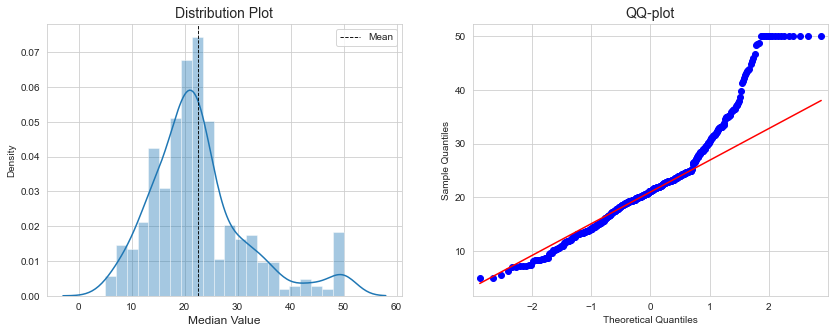

In [6]:
normal_test_plots(df.y, 'Median Value')

All the statistical tests for normality rejected that the null hypothesis the data comes from a normal distribution, as all our p-values are less than .05. Looking at our plots it seems that our data is not very symmetric, and starts deviating as the Median Value increases, and there is a pump when the Median Value equals 50.

Let's try transforming our response and perform the tests again.

## BoxCox Transformation

In [7]:
from scipy.stats import boxcox
y_boxcox= boxcox(df.y)

Skewness: 0.01583478691187103 
Skewness Test: Statistic = 0.14748955595457033 , p-value = 0.8827456227207489 
Excess Kurtosis: 0.5193352664240196 
Kurtosis Test: Statistic = 2.1193809488662883 , p-value = 0.034058285516800284 
Shapiro-Wilk Test: Statistic = 0.980028510093689 , p-value = 2.040514118561987e-06


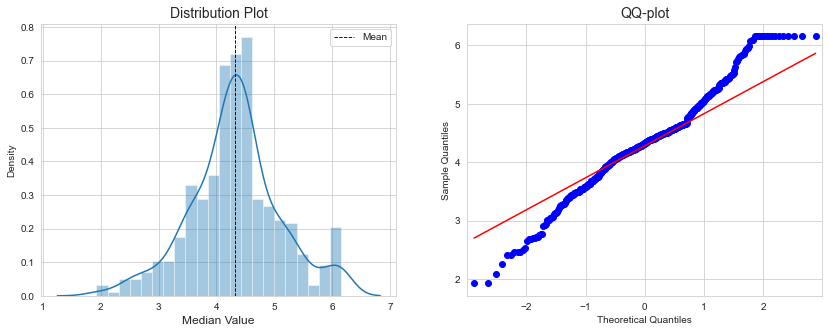

In [8]:
normal_test_plots(y_boxcox[0], 'Median Value')

This time we failed to reject the null hypothesis from our skewmess test, while our p-values improved in our other 2 tests. We still can see a bump in the highest Median Values, also making a light tail in our qq-plot. We'll check for outliers in our next steps and use our tranformed endogenous variable for our analysis.

In [9]:
df['y'] = y_boxcox[0]
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,4.572936
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,4.365582
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,5.336943
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,5.254954
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,5.428607


## Full Model 

We'll proceed to fit a full model using all our observations. We'll just take a quick look at our regression results and move right away to test if our residuals follow a normal distribution.

In [10]:
import statsmodels.formula.api as smf

In [11]:
# Function to obtain formula needed using statsmodels.formula.api
def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

In [12]:
formula = formula_from_cols(df.drop('y', axis=1),'y')
formula

'y ~ CRIM + ZN + INDUS + CHAS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT'

In [14]:
ols = smf.ols(formula, data=df)
model = ols.fit()
aic = model.aic
bic = model.bic
adj_r = model.rsquared_adj

print('Regression Results: '
      '\nAIC:', aic, '\nBIC:', bic, '\nAdj. R_sq:', adj_r)

Regression Results: 
AIC: 433.37195275467366 
BIC: 492.54346612469817 
Adj. R_sq: 0.7812111450375804


### Testing Normallity Residuals

We'll use externally studentized residuals for our analysis.

In [15]:
infl = model.get_influence()
esr = infl.get_resid_studentized_external()

Skewness: 0.7963108492302632 
Skewness Test: Statistic = 6.596780278515739 , p-value = 4.201827646655176e-11 
Excess Kurtosis: 3.2358583012130318 
Kurtosis Test: Statistic = 6.619245216382851 , p-value = 3.610375246146443e-11 
Shapiro-Wilk Test: Statistic = 0.9472568035125732 , p-value = 1.9205440189573597e-12


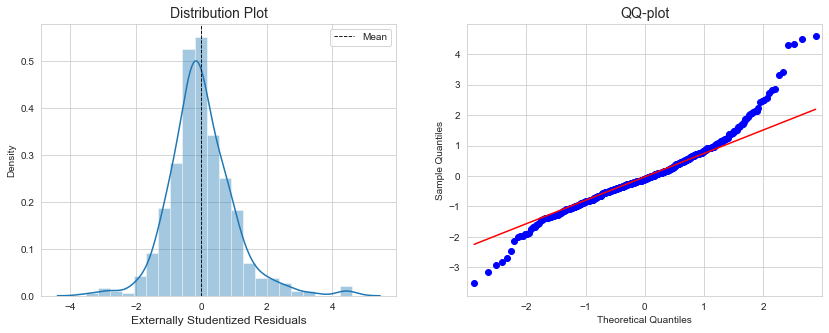

In [16]:
normal_test_plots(esr, 'Externally Studentized Residuals')

We rejected all our null hypothesis and we have a high excess kurtosis of 3.2. We'll proceed to detect outliers our data.  

## Leverage & Outliers

In [17]:
lev = infl.hat_matrix_diag*(df.shape[0]/df.shape[1])
cooks = infl.cooks_distance[0]
y_pred = model.predict(df)

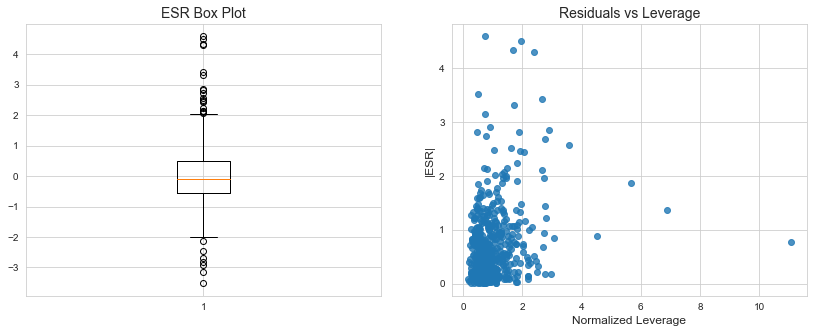

In [18]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].boxplot(esr)
ax[0].set_title('ESR Box Plot', size=14)
ax[1].scatter(lev, abs(esr), alpha=.8)
ax[1].set_title('Residuals vs Leverage', size=14)
ax[1].set_xlabel('Normalized Leverage', size=12)
ax[1].set_ylabel('|ESR|', size=12);

Our residulas box plot displays several potential outliers on both ends. We can also see some points over 3 standard deviations away from the mean. Our high leverage points are discarded as potential outliers.

We'll proceed to run a Generalized ESD to identify the outliers.

### Generalized ESD Test

Our function will perform a Grubb's test for one potential outlier and remove it if we reject the null hypothesis that the data point is not an outlier. It will iterate until we fail to reject the null hypothesis, and return a data frame of the residuals removed and a new data frame of our data without the points idenfied as outliers.

For each iteration it will print the following summary:

Statistic < Critical Value 

Studentized Residual Value

Mean of Studentized Residuals, Standard Deviation of Studentized Residuals (both for the current iteration)

In [19]:
def grubbs_test(x):
        
    # T-Statistic 
    xbar = np.mean(x)
    Sx = np.std(x, ddof=1)
    max_i = np.argmax(abs(x))
    ts = abs(x[max_i]-xbar)/Sx
    
    # Critical Value
    n = len(x)
    qt_sq = (stats.t.ppf(1-(.05/n), df=n-2))**2
    crit_val = ((n-1)/np.sqrt(n)) * (np.sqrt(qt_sq/(n-2+qt_sq)))
    
    return ts, crit_val, max_i, xbar, Sx

def ESD_generalized(df, endo_str):
    p = df.shape[1]
    esd_ts = .01
    esd_crit_val = 0
    count = 1 
    data_df = df.copy()
    oliers_arr = np.empty((1, p))
    
    formula = endo_str + ' ~ ' + ' + '.join([col for col in data_df.columns if not col==endo_str])
    
    # Iterate until not outlier is found
    while esd_ts > esd_crit_val:
        # Fit Model
        ols = smf.ols(formula, data=data_df)
        model = ols.fit()
        infl = model.get_influence()
        esr = infl.get_resid_studentized_external()
        
        # Run Grubbs test
        esd_ts, esd_crit_val, max_i, xbar, Sx = grubbs_test(esr)
        
        
        if esd_ts > esd_crit_val:
            
            print(f'Outlier {count}:\n {esd_ts} > {esd_crit_val} \nESR: {esr[max_i]} \nMean: {xbar}, SD: {Sx} \n')        
            # convert to array to make sure we work with the righ indices
            temp_arr = data_df.values 
            oliers_arr = np.concatenate((oliers_arr, temp_arr[max_i].reshape((1,p))))
            d = np.delete(temp_arr, max_i, axis=0) 
            data_df = pd.DataFrame(d, columns=list(data['feature_names'])+['y'])
            count += 1
        else: 
            print(f'Outlier {count}:\n {esd_ts} < {esd_crit_val} \nESR: {esr[max_i]} \nMean: {xbar}, SD: {Sx} \n')
    
    oliers_df = pd.DataFrame(np.delete(oliers_arr, 0, axis=0), columns=list(data['feature_names'])+['y'])
    return data_df, oliers_df     

In [21]:
new_df, oliers = ESD_generalized(df, 'y')

Outlier 1:
 4.558151372136522 > 3.69840981204702 
ESR: 4.588873263576777 
Mean: 0.0024220703178590686, SD: 1.0062086181023713 

Outlier 2:
 4.5584064557909825 > 3.6978736449246403 
ESR: 4.591967865628939 
Mean: 0.0025004536711477603, SD: 1.0068139944228423 

Outlier 3:
 4.622809785011017 > 3.6973363004352304 
ESR: 4.656643704178242 
Mean: 0.0025218633984844664, SD: 1.006773381822948 

Outlier 4:
 4.828572323794591 > 3.696797773577308 
ESR: 4.863094474970609 
Mean: 0.0023620380687465825, SD: 1.0066603772193263 

Outlier 5:
 3.8564085438899802 > 3.696258059317204 
ESR: 3.8846008403963954 
Mean: 0.0024329809799286807, SD: 1.006679612710458 

Outlier 6:
 3.991533784734944 > 3.69571715259083 
ESR: 4.019929086488091 
Mean: 0.0023039049873850048, SD: 1.0065366844358288 

Outlier 7:
 3.953657502401416 > 3.695175048300467 
ESR: 3.977353827972136 
Mean: 0.0018780329274843694, SD: 1.005518508527859 

Outlier 8:
 3.955267404683338 > 3.6946317413173757 
ESR: 3.978849387133868 
Mean: 0.0018512225081

### Identified Outliers Data Frame

In [22]:
oliers

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,9.23230,0.0,18.1,0.0,0.631,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,6.156526
1,18.81100,0.0,18.1,0.0,0.597,4.628,100.0,1.5539,24.0,666.0,20.2,28.79,34.37,4.007343
2,4.89822,0.0,18.1,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,6.156526
3,8.26725,0.0,18.1,1.0,0.668,5.875,89.6,1.1296,24.0,666.0,20.2,347.88,8.88,6.156526
4,13.52220,0.0,18.1,0.0,0.631,3.863,100.0,1.5106,24.0,666.0,20.2,131.42,13.33,4.497168
5,4.55587,0.0,18.1,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12,4.847955
6,18.49820,0.0,18.1,0.0,0.668,4.138,100.0,1.1370,24.0,666.0,20.2,396.90,37.97,3.534835
7,5.66998,0.0,18.1,1.0,0.631,6.683,96.8,1.3567,24.0,666.0,20.2,375.33,3.73,6.156526
8,14.23620,0.0,18.1,0.0,0.693,6.343,100.0,1.5741,24.0,666.0,20.2,396.90,20.32,2.463355
9,6.53876,0.0,18.1,1.0,0.631,7.016,97.5,1.2024,24.0,666.0,20.2,392.05,2.96,6.156526


### Data Frame Outliers Removed.

In [23]:
new_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,4.572936
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,4.365582
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,5.336943
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,5.254954
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,5.428607


Our function identified 10 outliers. Now let's fit again our full model without the outliers. 

### Fit Full Model Model Outliers Removed

In [24]:
ols = smf.ols(formula, data=new_df)
model = ols.fit()
aic = model.aic
bic = model.bic
adj_r = model.rsquared_adj

print('Regression Results: '
      '\nAIC:', aic, '\nBIC:', bic, '\nAdj. R_sq:', adj_r)

Regression Results: 
AIC: 247.8073871996628 
BIC: 306.6994501738118 
Adj. R_sq: 0.8388832872714947


Skewness: 0.12340082224854125 
Skewness Test: Statistic = 1.1342519540440457 , p-value = 0.2566888765855292 
Excess Kurtosis: 1.4994254119244923 
Kurtosis Test: Statistic = 4.352404096496561 , p-value = 1.346527798285125e-05 
Shapiro-Wilk Test: Statistic = 0.9750246405601501 , p-value = 1.72421792399291e-07


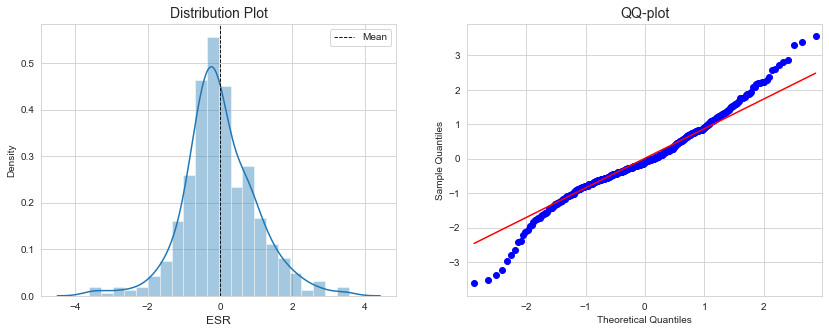

In [25]:
infl = model.get_influence()
esr = infl.get_resid_studentized_external()
normal_test_plots(esr, 'ESR')

Our AIC, BIC and Adj. R-squared all improved. We failed to reject the null hypothesis for our skewness test, and we rejected our null hypothesis for skewness, but we improved with an excess kurtosis of about 1.5. We can see from our qq-plot that we have heavy tails. 

We'll use this new data frame and proceed to train our model using a subset model.

# Model Training and Validation

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Subset Model

We'll continue or analysis using a subset model containing the following features: **CRIM, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT**

In [27]:
sub_selection = ['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT','y']
df_sub = new_df[sub_selection]

### Split Data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_sub.drop('y', axis=1), df_sub['y'], test_size=.3, random_state=279) 

### Fit Model

In [29]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
resid = y_pred - y_test
MSE = mean_squared_error(y_test, y_pred)
R_sq = lm.score(X_test, y_test)

print('MSE:', MSE,
      '\nR-square:', R_sq)

MSE: 0.06814569731870954 
R-square: 0.8684997661194775


Now let's check our model assumptions.

## Linearity

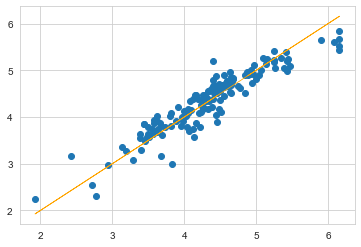

In [30]:
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, color='orange', lw=.8);

We have no indication of non-linearity in our model

## Normally Distributed Residuals

Skewness: -0.4897729392998745 
Skewness Test: Statistic = -2.4342275337133303 , p-value = 0.0149236106563094 
Excess Kurtosis: 0.9591336277787188 
Kurtosis Test: Statistic = 2.085317965792438 , p-value = 0.03704044769202376 
Shapiro-Wilk Test: Statistic = 0.9652630090713501 , p-value = 0.0008099583210423589


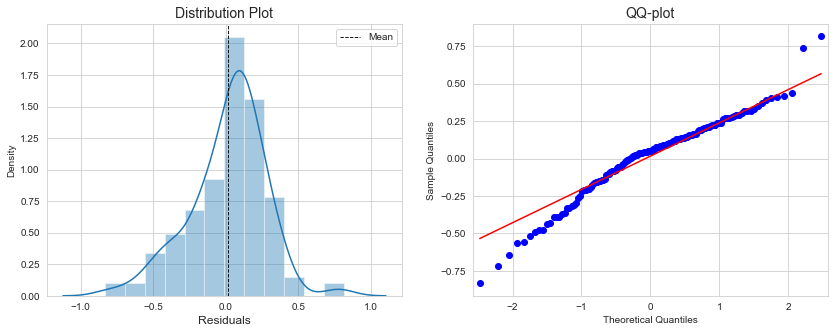

In [31]:
normal_test_plots(resid, 'Residuals')

We rejected our null hypothesis in all of our tests, but our Skewness and Kurtosis values, although in the borderline, are not too high.

## Homoscedasticity
We'll split our residuals in two and perform a Levine Test for equal variance.

Levine Test Results: 
Statistic = 0.26398798009985985 p-value = 0.6081649519470014


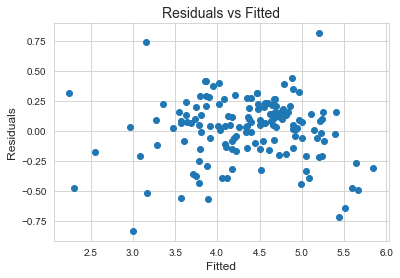

In [32]:
plt.scatter(y_pred, resid)
plt.title('Residuals vs Fitted', size=14)
plt.xlabel('Fitted', size=12)
plt.ylabel('Residuals', size=12)

# Separate residuals in two and perform test.
lev = stats.levene(resid[0:75], resid[75:])
print('Levine Test Results:',
      '\nStatistic =', lev[0], 'p-value =', lev[1])

With a p-value of 0.60 we failed to reject our null hypothesis that all input samples
are from populations with equal variances. We can see that the majority of our data oscillates around $\pm$0.50 with a few deviations around $\pm$0.75

## Multicollinearity

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [34]:
v = [variance_inflation_factor(df_sub.drop('y', axis=1).values,i) for i in range(df_sub.shape[1]-1)]
vif = pd.DataFrame(v, columns=['VIF'], index = df_sub.drop('y', axis=1).columns.values)
vif.sort_values('VIF')

,VIF
CRIM,1.993343
DIS,10.465549
LSTAT,12.495304
RAD,12.625569
AGE,20.828640
TAX,45.263323
PTRATIO,65.673329
NOX,66.873401
RM,72.696063


We have severe multicollinearity issues; however, since we limited the scope of our model to prediction only, we will not address it in this notebook.

We'll proceed to calculationg the prediction intervals

# Prediction Interval

Our function will compute the prediction interval for $n$ observations and return a data frame. We'll input the entire test data.

In [35]:
bhat = np.array([lm.intercept_]+list(lm.coef_))
var_resid = np.var(resid, ddof=1)

In [36]:
def get_pred_int(Xtrain, x, var_e, bhat):
    x = sm.add_constant(x)
    Xtrain = sm.add_constant(Xtrain)
    p = Xtrain.shape[1]
    # Checking x dimension
    if np.ndim(x) == 1:
        x = x.reshape((1, x.shape[0]))
    n = x.shape[0]
    
    # Get variance for n observations
    var_yhat = []
    inv = np.linalg.inv(Xtrain.T @ Xtrain)   
    for i in range(n):
        prod = x[i,:] @ inv @ x[i,:].T
        s = var_e * (1+prod)
        var_yhat.append(float(s))
    var_yhat = np.array(var_yhat)
    
    # Compute n confidence intervals
    df_pred_int = np.empty((1,3))
    qt = stats.t.ppf(.975, df=n-p)
    for j in range(n):
        yhat = x[j,:] @ bhat.reshape((p,1))
        lower = yhat - qt * np.sqrt(var_yhat[j])
        upper = yhat + qt * np.sqrt(var_yhat[j])
        vals = np.array((lower, yhat, upper)).reshape((1,3))
        df_pred_int = np.concatenate((df_pred_int, vals))

    # Make data frame
    df_pred_int = np.delete(df_pred_int,0,0)
    df_pred_int = pd.DataFrame(df_pred_int, columns=['lower bound', 'y_pred', 'upper bound'])
    
    
    return df_pred_int

In [37]:
pred_int_boxcox = get_pred_int(X_train.values, X_test.values, var_resid, bhat)
pred_int_boxcox

,lower bound,y_pred,upper bound
0,4.380322,4.900105,5.419888
1,4.522525,5.047577,5.572630
2,4.252084,4.775964,5.299845
3,4.912761,5.439581,5.966401
4,3.251710,3.782136,4.312563
...,...,...,...
144,4.620535,5.141346,5.662157
145,3.353003,3.875331,4.397658
146,3.106915,3.634722,4.162528
147,4.984922,5.513212,6.041501


We can transform back our values using the lambda value from the BoxCox transformation.

In [38]:
lambda_val = y_boxcox[1]
pred_int = pred_int_boxcox.apply(lambda x: round((1+x*lambda_val)**(1/lambda_val),1)).sort_values('y_pred')

In [39]:
print(pred_int.head(10))
print(pred_int[pred_int.y_pred.between(20,25)].head(10))
print(pred_int.tail(10))

     lower bound  y_pred  upper bound
129          4.1     6.2          9.1
124          4.2     6.5          9.5
114          5.3     7.6         10.6
24           7.1     9.9         13.5
44           7.2    10.1         13.8
29           7.7    10.6         14.4
104          7.9    11.1         15.2
142          7.9    11.2         15.5
87           8.7    11.9         16.0
15           8.8    12.0         16.1
     lower bound  y_pred  upper bound
21          15.0    20.0         26.1
133         15.1    20.0         26.1
11          15.1    20.0         26.1
37          15.4    20.4         26.6
12          16.1    21.3         27.7
42          16.1    21.3         27.7
65          16.3    21.4         27.8
106         16.2    21.5         27.9
110         16.3    21.5         27.9
93          16.3    21.6         28.0
     lower bound  y_pred  upper bound
119         25.9    33.4         42.4
134         26.1    33.5         42.6
53          27.7    35.6         45.1
116         

We can see that the higher the predicted value the wider the interval, so for the highest median values we can expect our predicted value to be in an interval of around $\pm 8$, around $\pm 6$ for the mid values, and around $\pm 3$ for the low values.